# Objective Function

In [1]:
import numpy as np
from typing import Tuple
def evalfunc(portfolio: np.ndarray, ret: np.ndarray, pi: float, theta: float) -> float:
    """
    Task 1: the objective function
    (Remember to vectorize as much as possible)


    Parameters
    --------------
    portfolio: np.ndarray: the portfolio vector i.e. x

    ret: np.ndarray: the (T, 3) numpy array containing all asset returns

    pi: float: the exponent parameter of the objective

    theta: the risk-aversion parameter of the objective


    Returns
    --------------
    float: the objective value.
    """
    # compute mean returns first. ret_mu shape should be (3,)
    ret_mu = ret.mean(axis=0)

    # first part
    drift = -ret_mu.dot(portfolio)

    # second part
    # weighed deviation from mean (part within []^pi)
    deviation = (ret - ret_mu).dot(portfolio)
    risk = theta * (
        (np.abs(deviation)**pi).mean()
    )
    return drift + risk

# Gradient

Following matrix notations, the objective function can be rewritten as
\begin{align*}
	\text{minimize} \ -\bar{\textbf{r}}'\textbf{x}
	+
	\frac{\theta}{T}
		||
			(\textbf{r} - \bar{\textbf{r}})'\textbf{x}
		||_{\pi}^{\pi}
\end{align*}
where $||\cdot||_\pi$ is the $L^\pi$ norm. Here we must investigate how to take the derivative of a $L^p$ norm with respect to the function argument. According to
[Wikipedia - Norm](https://en.wikipedia.org/wiki/Norm_(mathematics)),

\begin{align*}
\frac{\partial ||\textbf{x}||_p}{\partial \textbf{x}}&=\frac{\textbf{x}\circ |\textbf{x}|^{p-2}}{||\textbf{x}||_p^{p-1}}\\
\implies 
\frac{\partial ||\textbf{x}||_p^p}{\partial \textbf{x}}&=p\cdot||\textbf{x}||_p^{p-1}\cdot\frac{\textbf{x}\circ |\textbf{x}|^{p-2}}{||\textbf{x}||_p^{p-1}}\\
&=p\cdot \textbf{x}\circ |\textbf{x}|^{p-2}
\end{align*}
where $\circ$ is element-wise matrix multiplication, and $|\textbf{x}| = (|x_1|, \ldots, |x_n|)$ is the element-wise absolute value. In other words, 
\begin{align*}
\textbf{x}\circ |\textbf{x}|^{p-2}&=[x_1,\ldots, x_n]\circ [|x_1|^{p-2},\ldots, |x_n|^{p-2}]\\
&=[(x_1\cdot |x_1|^{p-2}),\ldots, (x_n\cdot |x_n|^{p-2})]
\end{align*}
Therefore, if we were to take derivative of the objective function with respect to $\textbf{x}$ can be obtained via chain rule:
\begin{align*}
\frac{\partial \text{obj}}{\partial \textbf{x}}
&=-\bar{\textbf{r}} + \frac{\pi\theta}{T}\cdot [(\textbf{r} - \bar{\textbf{r}})'\textbf{x}]\circ |(\textbf{r} - \bar{\textbf{r}})'\textbf{x}|^{\pi -2}\cdot (\textbf{r}-\bar{\textbf{r}})
\end{align*}

In [2]:
def evalgrad(portfolio: np.ndarray, ret: np.ndarray, pi: float, theta: float) -> np.ndarray:
    """
    Task 1: the objective function gradient


    Parameters
    --------------
    portfolio: np.ndarray: the portfolio vector i.e. x

    ret: np.ndarray: the (T, 3) numpy array containing all asset returns

    pi: float: the exponent parameter of the objective

    theta: the risk-aversion parameter of the objective


    Returns
    --------------
    float: the objective gradient vector
    """
    T = ret.shape[0]
    ret_mu = ret.mean(axis=0)
    delta = ret - ret_mu
    dev = delta.dot(portfolio)
    nom = dev * np.absolute(dev)**(pi-2)
    return -ret_mu + (
        (theta * pi/ T)*nom
    ).dot(delta)


# Data processing

In [3]:
import pandas as pd
import datetime

def is_open_or_noon(dt: datetime.datetime) -> bool:
    """Task 1: read helper function for datetime parsing"""
    t = dt.time()
    return t == datetime.time(9,30) or t == datetime.time(12,0)

def is_open(dt:datetime.datetime) -> bool:
    """Task 1: read helper function for datetime parsing"""
    return dt.time() == datetime.time(9,30)

def my_dt_parser(s: str) -> datetime.datetime:
    """Task 1: custom datetime parser. 5x faster than pd.to_datetime"""
    # 2021-02-01 09:30:00
    date, time = s.split()
    if "/" in date:
        m, d, y = date.split("/")
        year = 2000 + int(y)
    elif "-" in date:
        y, m, d = date.split("-")
        year = int(y)
    else:
        raise Exception("DATETIME PARSING ERROR!")

    HM = time.split(":")
    H, M = HM[0], HM[1]
    return datetime.datetime(
        year = year,
        month = int(m),
        day = int(d),
        hour = int(H),
        minute = int(M)
    )

def read_asset(asset:str, data_dir: str="../data/project_4_data/") -> pd.DataFrame:
    """
    Task 1: reads a single asset.


    Parameters
    --------------
    asset: str: asset name

    data_dir: str: local data directory


    Returns
    --------------
    pd.DataFrame: pandas dataframe containing asset returns and price
    """
    # static var to mark missing data
    missing = -999.
    # read csv
    csv_path = data_dir + asset + ".csv"
    df = pd.read_csv(csv_path, low_memory=False, header=3).loc[:, ["Dates", "Close"]]
    # read up to empty entries
    df = df.iloc[:df["Close"].isna().argmax()]

    # deal with first row missing date
    df.loc[0,"Dates"] = df.loc[1,"Dates"].replace("31", "30")
    if asset == 'AMZN':
        df.loc[df['Dates'] == '4/20/21 12:01', 'Dates'] = '4/20/21 12:00'
        df.loc[df['Dates'] == '6/14/21 12:01', 'Dates'] = '6/14/21 12:00'
    if asset == 'ABR':
        df.loc[df['Dates'] == '2021-02-01 12:01:00', 'Dates'] = '2021-02-01 12:00:00'
        df.loc[df['Dates'] == '2021-02-03 12:01:00', 'Dates'] = '2021-02-03 12:00:00'
        df.loc[df['Dates'] == '2021-02-18 12:01:00', 'Dates'] = '2021-02-18 12:00:00'
        df.loc[df['Dates'] == '2021-03-02 12:01:00', 'Dates'] = '2021-03-02 12:00:00'
        df.loc[df['Dates'] == '2021-03-08 12:01:00', 'Dates'] = '2021-03-08 12:00:00'
        df.loc[df['Dates'] == '2021-03-23 12:01:00', 'Dates'] = '2021-03-23 12:00:00'
        df.loc[df['Dates'] == '2021-06-04 12:01:00', 'Dates'] = '2021-06-04 12:00:00'
        df.loc[df['Dates'] == '2021-06-16 12:01:00', 'Dates'] = '2021-06-16 12:00:00'
    if asset == 'UBS':
        df.loc[df['Dates'] == '2021-02-02 12:01:00', 'Dates'] = '2021-02-02 12:00:00'
        df.loc[df['Dates'] == '2021-02-04 12:01:00', 'Dates'] = '2021-02-04 12:00:00'
        df.loc[df['Dates'] == '2021-02-11 12:01:00', 'Dates'] = '2021-02-11 12:00:00'
        df.loc[df['Dates'] == '2021-02-18 12:01:00', 'Dates'] = '2021-02-18 12:00:00'
        df.loc[df['Dates'] == '2021-02-19 12:01:00', 'Dates'] = '2021-02-19 12:00:00'
        df.loc[df['Dates'] == '2021-03-26 12:01:00', 'Dates'] = '2021-03-26 12:00:00'
        df.loc[df['Dates'] == '2021-03-31 12:02:00', 'Dates'] = '2021-03-31 12:00:00'
        df.loc[df['Dates'] == '2021-04-06 12:01:00', 'Dates'] = '2021-04-06 12:00:00'
        df.loc[df['Dates'] == '2021-04-19 12:01:00', 'Dates'] = '2021-04-19 12:00:00'
        df.loc[df['Dates'] == '2021-04-30 12:05:00', 'Dates'] = '2021-04-30 12:00:00'
        df.loc[df['Dates'] == '2021-07-23 12:01:00', 'Dates'] = '2021-07-23 12:00:00'

    # extract open or noon data
    df["dt"] = df["Dates"].apply(my_dt_parser)
    df["Date"] = df["dt"].apply(lambda dt: dt.date())
    open_or_noon = df["dt"].apply(is_open_or_noon)
    df = df.loc[open_or_noon]

    # compute daily return
    ret = df.loc[:, ["Close","Date"]].groupby("Date").apply(
        lambda x: x["Close"].iloc[1]/x["Close"].iloc[0]-1 if len(x) == 2 else missing
    ).values

    ret = ret[~np.isnan(ret)]

    # return along with daily open price
    df = df.loc[df["dt"].apply(is_open)]
    df["ret"] = ret

    # filter out bad dates with missing data (particularly at noon)
    df = df.loc[df.ret > missing + 1]
    df.set_index("Date", inplace=True)
    df = df[["ret", "Close"]]
    df.rename(columns = {"ret": f"{asset}_ret", "Close": f"{asset}_price"}, inplace = True)
    return df

assets = ["ABR", "AMZN", "GS", "NFLX", "NIO", "NVDA", "TSLA", "UBS"]

for a in assets:
    asset = read_asset(a)
    print("Name:", a)
    print(asset)
    print()

Name: ABR
             ABR_ret  ABR_price
Date                           
2021-02-01 -0.011845    14.3601
2021-02-02  0.014195    14.5830
2021-02-03  0.001273    14.8500
2021-02-04  0.034797    14.8000
2021-02-05 -0.002571    15.5600
...              ...        ...
2021-08-09  0.007619    18.2311
2021-08-10  0.006014    18.2900
2021-08-11 -0.004968    18.6200
2021-08-12 -0.005870    18.7400
2021-08-13 -0.000545    18.3600

[136 rows x 2 columns]

Name: AMZN
            AMZN_ret  AMZN_price
Date                            
2021-01-04 -0.027139     3262.80
2021-01-05  0.006993     3174.80
2021-01-06  0.010673     3146.17
2021-01-07  0.010303     3162.20
2021-01-08 -0.005051     3173.77
...              ...         ...
2021-07-07 -0.004655     3729.24
2021-07-08  0.004955     3652.90
2021-07-09  0.002678     3718.54
2021-07-12 -0.011032     3746.21
2021-07-13  0.011858     3708.82

[132 rows x 2 columns]

Name: GS
              GS_ret  GS_price
Date                          
2021-01-11  0

In [4]:
def read_all(data_dir: str = "../data/project_4_data/", T: int = 100) -> Tuple[pd.DataFrame,pd.DataFrame]:
    """
    Task 1.5: reads all asset returns and sever into train and test.


    Parameters
    --------------
    data_dir: str: local data directory

    T: int: size of the traning period.


    Returns
    --------------
    Tuple[pd.DataFrame, pd.DataFrame]: train and test pandas dataframe containing returns and prices
    """
    assets = ["ABR", "AMZN", "GS", "NFLX", "NIO", "NVDA", "TSLA", "UBS"]

    dfs = [read_asset(asset, data_dir) for asset in assets]

    df = dfs[0]
    for i in range(1, len(assets)):
        df = df.join(dfs[i])

    df = df.dropna()
    return df.iloc[:T], df.iloc[T:]

train, test = read_all(T=111)

In [5]:
# split
ret_train = train.loc[:,[col for col in train.columns if "ret" in col]]
price_train = train.loc[:,[col for col in train.columns if "price" in col]]
ret_test = test.loc[:,[col for col in test.columns if "ret" in col]].values
price_test= test.loc[:,[col for col in test.columns if "price" in col]].values

# Main Algorithm: Gradient Descent

In [6]:
def backtrack(
    x: np.ndarray,
    ret: np.ndarray,
    pi: float,
    theta: float,
    fval: float,
    grad: np.ndarray,
    delta: np.ndarray,
    alpha: float = 0.5,
    beta: float = 0.75,
    step_eps: float = 1e-4,
    init_step: float = 1,
) -> Tuple[float, bool]:
    """
    Task 1: backtrack step finder


    Parameters
    --------------
    x: np.ndarray: portfolio weights

    ret: np.ndarray: return matrix

    pi: float: the exponent parameter of the objective

    theta: the risk-aversion parameter of the objective

    fval: float: current functional value

    grad: np.ndarray: gradient

    delta: np.ndarray: direction vector

    alpha: float: acceptance threshold

    beta: float: shrink ratio

    step_eps: float: the tolerance lower bound of backtrack step

    init_step: float: intial step size


    Returns
    --------------
    Tuple[float, bool]: optimal step size, success boolean
    """
    grad_dot_delta = grad.dot(delta)
    step = init_step
    goon = True
    success = False

    while goon:
        fnew = evalfunc(x + step * delta, ret, pi, theta)
        target = alpha * step * grad_dot_delta

        if fnew - fval <= target:
            goon = False
            success = True
        else:
            step *= beta
        if step < step_eps:
            goon = False
    return step, success


def get_descent(
    step: float,
    grad: np.ndarray,
    momentum: bool = False,
    olddelta: np.ndarray = None,
    mu: float = None,
) -> np.ndarray:
    """
    Task 1: helper function to generate the descent step,
    for both momentum and non-momentum case.


    Parameters
    --------------
    step: float: step size

    grad: np.ndarray: gradient

    momentum: bool: momentum flag

    olddelta: np.ndarray: moving average vector for momentum

    mu: float: conservation parameter for momentum descent

    Returns
    --------------
    np.ndarray: descent step
    """
    # delta = -grad
    # delta[np.logical_or(delta > 1, delta < -1)] = 0
    # if not momentum:
    #     # if not momentum just negative gradient direction times step size
    #     return step * delta
    # else:
    #     # if momentum the convex combination of moving average and conventional step
    #     assert (olddelta is not None) and (mu is not None)
    #     return step * delta + (1 - mu) * olddelta
    
    if not momentum:
        # if not momentum just negative gradient direction times step size
        delta = -grad
    else:
        # if momentum the convex combination of moving average and conventional step
        assert (olddelta is not None) and (mu is not None)
        delta = -grad + (1 - mu) * olddelta

    delta[np.logical_or(delta > 1, delta < -1)] = 0
    return step * delta


def run_grad_desc(
    x: np.ndarray,
    ret: np.ndarray,
    pi: float,
    theta: float,
    x_history: np.ndarray,
    f_history: np.ndarray,
    bt: bool = True,
    bt_a: float = None,
    bt_b: float = None,
    bt_init_step: float = 1,
    momentum: bool = False,
    mom_mu: float = None,
    max_iter: int = 1000,
    step_eps: float = 0.05,
) -> Tuple[bool, np.ndarray]:
    """
    Task 1: Main GD algorithm. Incorporates the possibility to toggle
    both the momentum flag and the backtrack flag.


    Parameters
    --------------
    x: np.ndarray: portfolio weights

    ret: np.ndarray: return matrix

    pi: float: the exponent parameter of the objective

    theta: float: the risk-aversion parameter of the objective

    x_history: np.ndarray: portfolio weight vector

    f_history: np.ndarray: objective vector

    bt: bool: backtrack flag. If False, use constant step specified by step_eps.

    bt_a: float: backtrack acceptance threshold

    bt_b: float: backtrack shrink ratio

    bt_init_step: float: backtrack initial step size, default 1.

    momentum: bool: momentum flag

    mom_mu: float: momentum conservation parameter

    max_iter: int: iteration limit

    step_eps: float: the tolerance lower bound of backtrack step if bt=True,
    the step size if bt=False.
    """
    converged = False
    iter = 0
    descent = np.zeros_like(x)
    while iter < max_iter:
        x_history[iter] = x
        fval = evalfunc(x, ret, pi, theta)
        grad = evalgrad(x, ret, pi, theta)
        f_history[iter] = fval
        if bt:
            # if backtrack, call backtrack function to compute step size
            step, goodstep = backtrack(
                x, ret, pi, theta, fval, grad, -grad, bt_a, bt_b, step_eps, bt_init_step
            )
            goodstep = True
        else:
            # if not, use constant step size
            goodstep = True
            step = step_eps

        # one line to compute descent for both momentum and non-momentum case
        descent = get_descent(step, grad, momentum, descent, mom_mu)
        if goodstep:
            # if good step, descend
            x = np.minimum(np.maximum(-1, x + descent), 1)

            # if np.inner(grad, grad) < 1e-7:
            is_at_boundary = np.isclose(np.abs(x), 1)
            is_zero_grad = np.isclose(grad, 0)
            if np.logical_or(is_at_boundary, is_zero_grad).all():
                converged = True
                print("Converged. x:", x)
                break
            else:
                pass
                # if iter % 100 == 0:
                #     print(f"grad {iter} = {grad}")
                #     print(f"grad L2 {iter} = {np.inner(grad, grad)}")
        iter += 1
    return iter, converged

# Demo Runs

$\pi = 2$, $\theta = 5$ for $100000$ iterations. 

Expected behavior: since almost no risk aversion is factored into the objective, the objective and weights should diverge to negative infinity since all three assets have negative mean returns in training data.


In [7]:
ret = ret_train.values
pi = 2; theta = 5; portfolio = np.array([1/8]*8)
max_iter = 100000
m = len(portfolio)
x_history = np.zeros((max_iter, m))
f_history = np.zeros(max_iter)
it, converged = run_grad_desc(
    x = portfolio, 
    ret = ret, 
    pi = pi, theta = theta, x_history = x_history, f_history = f_history,
    bt=True, bt_a=0.5, bt_b=0.75, bt_init_step=1,
    momentum=False, mom_mu=0.8, 
    max_iter = max_iter, step_eps=1e-4, 
)

print(f"Converged: {str(converged)}, after {it} iterations")

Converged. x: [ 0.04342216  0.48675894  0.34648605 -0.16472682 -0.02067607  0.38667856
 -0.61599506  1.        ]
Converged: True, after 22275 iterations


Final objective = -0.00133
Final portfolio = [0.04342, 0.48676, 0.34649, -0.16473, -0.02068, 0.38668, -0.616, 1.0]


Text(0.5, 1.0, 'Pi = 2, Theta = 5,\nFinal portfolio = [0.04342, 0.48676, 0.34649, -0.16473, -0.02068, 0.38668, -0.616, 1.0]')

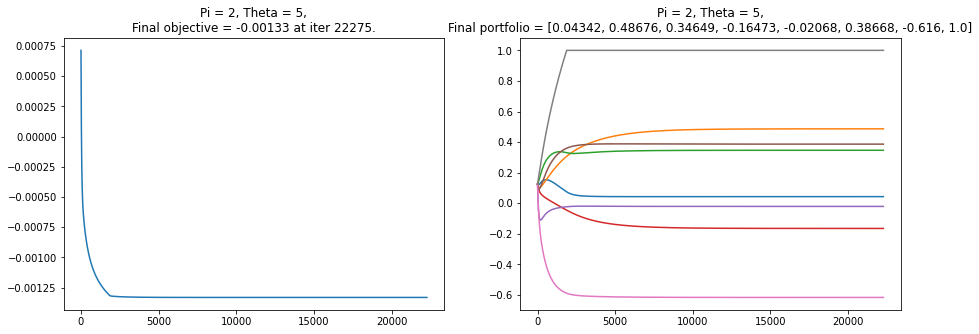

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize= (15, 5))

ax[0].plot(f_history[:it])
ax[1].plot(x_history[:it])

final_objective = round(f_history[it-1],5)
final_portfolio = [round(p,5) for p in x_history[it-1]]
print(f"Final objective = {final_objective}")
print(f"Final portfolio = {final_portfolio}")

ax[0].set_title(f"Pi = {pi}, Theta = {theta},\nFinal objective = {final_objective} at iter {it}.")
ax[1].set_title(f"Pi = {pi}, Theta = {theta},\nFinal portfolio = {final_portfolio}")

$\pi = 4$, $\theta = 1000$ for $100000$ iterations. 

Expected behavior: since almost no risk aversion is factored into the objective, the objective and weights should diverge to negative infinity since all three assets have negative mean returns in training data.


In [9]:
ret = ret_train.values
pi = 4; theta = 1000; portfolio = np.array([1/8]*8)
max_iter = 100000
m = len(portfolio)
x_history = np.zeros((max_iter, m))
f_history = np.zeros(max_iter)
it, converged = run_grad_desc(
    x = portfolio, 
    ret = ret, 
    pi = pi, theta = theta, x_history = x_history, f_history = f_history,
    bt=True, bt_a=0.5, bt_b=0.6, bt_init_step=1,
    momentum=False, mom_mu=0.8, 
    max_iter = max_iter, step_eps=1e-4, 
)

print(f"Converged: {str(converged)}, after {it} iterations")

Converged. x: [ 0.22586562  0.7223805   0.69345482 -0.03153003  0.03701223  0.54047823
 -1.          1.        ]
Converged: True, after 46911 iterations


Final objective = -0.00257
Final portfolio = [0.22587, 0.72238, 0.69345, -0.03153, 0.03701, 0.54048, -1.0, 1.0]


Text(0.5, 1.0, 'Pi = 4, Theta = 1000,\nFinal portfolio = [0.22587, 0.72238, 0.69345, -0.03153, 0.03701, 0.54048, -1.0, 1.0]')

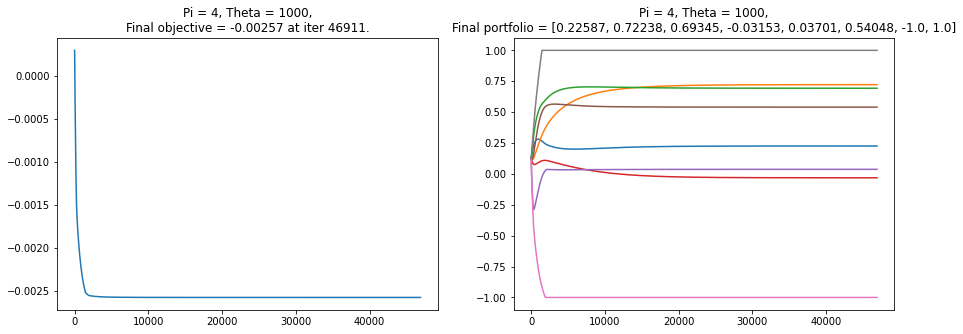

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize= (15, 5))

ax[0].plot(f_history[:it])
ax[1].plot(x_history[:it])

final_objective = round(f_history[it-1],5)
final_portfolio = [round(p,5) for p in x_history[it-1]]
print(f"Final objective = {final_objective}")
print(f"Final portfolio = {final_portfolio}")

ax[0].set_title(f"Pi = {pi}, Theta = {theta},\nFinal objective = {final_objective} at iter {it}.")
ax[1].set_title(f"Pi = {pi}, Theta = {theta},\nFinal portfolio = {final_portfolio}")

# Full runs

In [12]:
import itertools 

res = []

m = 8
x = np.ones(m)/m
bt_a = 0.5; bt_b=0.75; bt_init_step=1; max_iter=100000

for theta,pi in [(5,2), (1000,4)]:
    for bt,mom in list(itertools.product([True, False], [True,False])):
        step_epss = [1e-8] if bt else [0.1, 1]
        mom_mus = [0.8, 0.9] if mom else [1]
        for step_eps,mom_mu in list(itertools.product(step_epss,mom_mus)):
            print("*"*60)
            print(f"RUNNING: theta={theta}, pi={pi}, bt={bt}, mom={mom}...")
            x_history = np.zeros((max_iter, m))
            f_history = np.zeros(max_iter)
            it, converged = run_grad_desc(
                x = x, 
                ret = ret, 
                pi = pi, theta = theta, x_history = x_history, f_history = f_history,
                bt=bt, bt_a=bt_a, bt_b=bt_b, bt_init_step=1,
                momentum=mom, mom_mu=mom_mu, 
                max_iter = max_iter, step_eps=step_eps, 
            )
            res.append({
                    "theta": theta,
                    "pi": pi,
                    "backtrack": bt,
                    "momentum": mom,
                    "momentum_mu": mom_mu, 
                    "step_size/step_eps": step_eps,
                    "converged": converged,
                    "converged_iter": it,
                    "final_objective": f_history[it-1],
                    "final_portfolio": x_history[it-1]
                })
result_df = pd.DataFrame(res)

************************************************************
RUNNING: theta=5, pi=2, bt=True, mom=True...
Converged. x: [ 0.04342216  0.48675895  0.34648605 -0.16472683 -0.02067607  0.38667856
 -0.61599506  1.        ]
************************************************************
RUNNING: theta=5, pi=2, bt=True, mom=True...
Converged. x: [ 0.04342216  0.48675895  0.34648605 -0.16472682 -0.02067607  0.38667856
 -0.61599506  1.        ]
************************************************************
RUNNING: theta=5, pi=2, bt=True, mom=False...
Converged. x: [ 0.04342216  0.48675894  0.34648605 -0.16472682 -0.02067607  0.38667856
 -0.61599506  1.        ]
************************************************************
RUNNING: theta=5, pi=2, bt=False, mom=True...
************************************************************
RUNNING: theta=5, pi=2, bt=False, mom=True...
************************************************************
RUNNING: theta=5, pi=2, bt=False, mom=True...
Converged. x: [ 0.043

## Result

In [14]:
result_df

,theta,pi,backtrack,momentum,momentum_mu,step_size/step_eps,converged,converged_iter,final_objective,final_portfolio
0,5,2,True,True,0.8,1.000000e-08,True,17817,-0.001332,"[0.04342215468058013, 0.4867589252043032, 0.34..."
1,5,2,True,True,0.9,1.000000e-08,True,20046,-0.001332,"[0.04342215467929504, 0.48675892355881845, 0.3..."
2,5,2,True,False,1.0,1.000000e-08,True,22275,-0.001332,"[0.04342215471873433, 0.4867589247370726, 0.34..."
3,5,2,False,True,0.8,1.000000e-01,False,100000,-0.001332,"[0.043351368694511984, 0.4820710187999342, 0.3..."
4,5,2,False,True,0.9,1.000000e-01,False,100000,-0.001332,"[0.043348499365466135, 0.4818517242816253, 0.3..."
5,5,2,False,True,0.8,1.000000e+00,True,17817,-0.001332,"[0.04342215468058013, 0.4867589252043032, 0.34..."
6,5,2,False,True,0.9,1.000000e+00,True,20046,-0.001332,"[0.04342215467929504, 0.48675892355881845, 0.3..."
7,5,2,False,False,1.0,1.000000e-01,False,100000,-0.001332,"[0.04334559692244109, 0.48162693565235354, 0.3..."
8,5,2,False,False,1.0,1.000000e+00,True,22275,-0.001332,"[0.04342215471873433, 0.4867589247370726, 0.34..."
9,1000,4,True,True,0.8,1.000000e-08,True,37526,-0.002574,"[0.22586560988470683, 0.7223804772045535, 0.69..."


## Parameter sets failed to converge


In [13]:
result_df[result_df['converged']==False]

,theta,pi,backtrack,momentum,momentum_mu,step_size/step_eps,converged,converged_iter,final_objective,final_portfolio
3,5,2,False,True,0.8,0.1,False,100000,-0.001332,"[0.043351368694511984, 0.4820710187999342, 0.3..."
4,5,2,False,True,0.9,0.1,False,100000,-0.001332,"[0.043348499365466135, 0.4818517242816253, 0.3..."
7,5,2,False,False,1.0,0.1,False,100000,-0.001332,"[0.04334559692244109, 0.48162693565235354, 0.3..."
12,1000,4,False,True,0.8,0.1,False,100000,-0.002574,"[0.2093664670324923, 0.6712702946549176, 0.703..."
13,1000,4,False,True,0.9,0.1,False,100000,-0.002574,"[0.2091057649314297, 0.670204299614882, 0.7032..."
16,1000,4,False,False,1.0,0.1,False,100000,-0.002574,"[0.20884837361080616, 0.6691359314306098, 0.70..."


## Best results

In [15]:
groupby_best_idx = result_df.loc[:,["theta", "pi", "final_objective"]].groupby(["theta", "pi"]).idxmin().values.flatten()
groupby_best = result_df.iloc[groupby_best_idx]
groupby_best

,theta,pi,backtrack,momentum,momentum_mu,step_size/step_eps,converged,converged_iter,final_objective,final_portfolio
0,5,2,True,True,0.8,1.000000e-08,True,17817,-0.001332,"[0.04342215468058013, 0.4867589252043032, 0.34..."
10,1000,4,True,True,0.9,1.000000e-08,True,42219,-0.002574,"[0.22586561216209003, 0.7223804832721062, 0.69..."


In [16]:
# extract x_star for extra credit

x_star = groupby_best.final_portfolio.values

# Extra Credit: Nonlinear constraint

Consider that the barrier slack is given by

\begin{align*}
    s&=0.5\cdot \sum_j |x^*_j| - \sum_j|x_j|\\
    &\equiv 0.5 ||\textbf{x}^*||_1 - ||\textbf{x}||_1\\
    \implies \frac{\partial s}{\partial \textbf{x}}&=\frac{\partial ||\textbf{x}||_1}{\partial \textbf{x}}\\
    &=-\text{sign}(\textbf{x})
\end{align*}
where the sign function applies element-wise ($1$ if positive, $-1$ if negative).

In [18]:
def barrier(x, x_star, kind="log", lda = 10):
    slack = 0.5 * np.abs(x_star).sum() - np.abs(x).sum()

    if kind == "log":
        if slack > 0:
            return -lda * np.log(slack)
        else:
            print("INVALID SLACK!!!")
            print("Slack =", slack)
            print("x =", x)
            print("x_star =", x_star)
            return -lda * np.log(slack)
    else:
        raise NotImplementedError

def evalfunc_barrier(portfolio: np.ndarray, x_star: np.ndarray, lda: float, ret: np.ndarray, pi: float, theta: float) -> float:
    """
    Task 1: the objective function
    (Remember to vectorize as much as possible)


    Parameters
    --------------
    portfolio: np.ndarray: the portfolio vector i.e. x

    ret: np.ndarray: the (T, 3) numpy array containing all asset returns

    pi: float: the exponent parameter of the objective

    theta: the risk-aversion parameter of the objective


    Returns
    --------------
    float: the objective value.
    """
    # compute mean returns first. ret_mu shape should be (3,)
    ret_mu = ret.mean(axis=0)

    # first part
    drift = -ret_mu.dot(portfolio)

    # second part
    # weighed deviation from mean (part within []^pi)
    deviation = (ret - ret_mu).dot(portfolio)
    risk = theta * (
        (np.abs(deviation)**pi).mean()
    )
    b = barrier(portfolio, x_star, lda=lda)
    return drift + risk + b

def evalgrad_barrier(portfolio: np.ndarray, x_star:np.ndarray, lda: float, ret: np.ndarray, pi: float, theta: float) -> np.ndarray:
    """
    Task 1: the objective function gradient


    Parameters
    --------------
    portfolio: np.ndarray: the portfolio vector i.e. x

    ret: np.ndarray: the (T, 3) numpy array containing all asset returns

    pi: float: the exponent parameter of the objective

    theta: the risk-aversion parameter of the objective


    Returns
    --------------
    float: the objective gradient vector
    """
    T = ret.shape[0]
    ret_mu = ret.mean(axis=0)
    delta = ret - ret_mu
    dev = delta.dot(portfolio)
    nom = dev * np.absolute(dev)**(pi-2)
    slack = 0.5 * np.abs(x_star).sum() - np.abs(portfolio).sum()
    db = -lda / slack * (-np.sign(slack))
    return -ret_mu + (
        (theta * pi/ T)*nom
    ).dot(delta) + db

# x = np.array([1/8]*8)
# x_star = np.array([0.30413, 0.01365, 0.00862, -0.10567, 0.03021, 0.35313, -0.58899, 1.0])
# lda = 10
# evalgrad_barrier(x, x_star, lda, ret, 2, 5)

In [19]:
def backtrack_barrier(
    x: np.ndarray,
    x_star:np.ndarray,
    lda: float,
    ret: np.ndarray,
    pi: float,
    theta: float,
    fval: float,
    grad: np.ndarray,
    delta: np.ndarray,
    alpha: float = 0.5,
    beta: float = 0.75,
    step_eps: float = 1e-4,
    init_step: float = 1,
) -> Tuple[float, bool]:
    """
    Task 1: backtrack step finder


    Parameters
    --------------
    x: np.ndarray: portfolio weights

    ret: np.ndarray: return matrix

    pi: float: the exponent parameter of the objective

    theta: the risk-aversion parameter of the objective

    fval: float: current functional value

    grad: np.ndarray: gradient

    delta: np.ndarray: direction vector

    alpha: float: acceptance threshold

    beta: float: shrink ratio

    step_eps: float: the tolerance lower bound of backtrack step

    init_step: float: intial step size


    Returns
    --------------
    Tuple[float, bool]: optimal step size, success boolean
    """
    grad_dot_delta = grad.dot(delta)
    D = delta.shape[0]
    step = init_step
    step_eps = 1e-10
    epsilon = 1e-2

    # barrier constraint
    for i in range(D):
        newxi = x[i] + step * delta[i]
        if newxi + epsilon >= 1:
            step = (1 - x[i] - epsilon) / delta[i]
        elif newxi - epsilon <= -1:
            step = (-1 + epsilon - x[i]) / delta[i]
    
    # print("\tAfter box contraint:", step)
    # total constraint
    for i in range(D):
        newx = np.copy(x)
        newx[i] = x[i] + step * delta[i]
        if np.abs(newx).sum() + epsilon > 0.5 * np.abs(x_star).sum():
            newxsum = 0.5 * np.abs(x_star).sum() - epsilon
            absnewxi = newxsum - np.abs(np.delete(newx, i)).sum()
            newx_target = absnewxi if newx[i] > 0 else -absnewxi
            step = (newx_target - x[i]) / delta[i]

    # print("\tStep after logic:", step) 

    goon = True
    success = False
    while goon:
        # fnew = evalfunc(x + step * delta, ret, pi, theta)
        fnew = evalfunc_barrier(
            x + step * delta, x_star, lda, ret, pi, theta
        )
        
        target = alpha * step * grad_dot_delta

        if fnew - fval <= target:
            goon = False
            success = True
        else:
            step *= beta
        if step < step_eps:
            goon = False
    return step, success


def get_descent(
    x: np.ndarray,
    step: float,
    grad: np.ndarray,
    momentum: bool = False,
    olddelta: np.ndarray = None,
    mu: float = None,
) -> np.ndarray:
    """
    Task 1: helper function to generate the descent step,
    for both momentum and non-momentum case.


    Parameters
    --------------
    step: float: step size

    grad: np.ndarray: gradient

    momentum: bool: momentum flag

    olddelta: np.ndarray: moving average vector for momentum

    mu: float: conservation parameter for momentum descent

    Returns
    --------------
    np.ndarray: descent step
    """
    delta = -grad
    delta[np.logical_or(x > 1, x < -1)] = 0
    if not momentum:
        # if not momentum just negative gradient direction times step size
        return step * delta
    else:
        # if momentum the convex combination of moving average and conventional step
        assert (olddelta is not None) and (mu is not None)
        return step * delta + (1 - mu) * olddelta


def run_grad_desc_barrier(
    x: np.ndarray,
    x_star: np.ndarray,
    lda: float,
    ret: np.ndarray,
    pi: float,
    theta: float,
    x_history: np.ndarray,
    f_history: np.ndarray,
    bt: bool = True,
    bt_a: float = None,
    bt_b: float = None,
    bt_init_step: float = 1,
    momentum: bool = False,
    mom_mu: float = None,
    max_iter: int = 1000,
    step_eps: float = 0.05,
) -> Tuple[bool, np.ndarray]:
    """
    Task 1: Main GD algorithm. Incorporates the possibility to toggle
    both the momentum flag and the backtrack flag.


    Parameters
    --------------
    x: np.ndarray: portfolio weights

    ret: np.ndarray: return matrix

    pi: float: the exponent parameter of the objective

    theta: float: the risk-aversion parameter of the objective

    x_history: np.ndarray: portfolio weight vector

    f_history: np.ndarray: objective vector

    bt: bool: backtrack flag. If False, use constant step specified by step_eps.

    bt_a: float: backtrack acceptance threshold

    bt_b: float: backtrack shrink ratio

    bt_init_step: float: backtrack initial step size, default 1.

    momentum: bool: momentum flag

    mom_mu: float: momentum conservation parameter

    max_iter: int: iteration limit

    step_eps: float: the tolerance lower bound of backtrack step if bt=True,
    the step size if bt=False.
    """
    converged = False
    iter = 0
    window = 30
    descent = np.zeros_like(x)
    while iter < max_iter:
        x_history[iter] = x
        # fval = evalfunc(x, ret, pi, theta)
        # grad = evalgrad(x, ret, pi, theta)
        fval = evalfunc_barrier(x, x_star, lda, ret, pi, theta)
        grad = evalgrad_barrier(x, x_star, lda, ret, pi, theta)
        f_history[iter] = fval
        if bt:
            # if backtrack, call backtrack function to compute step size
            step, goodstep = backtrack_barrier(
                x, x_star, lda, ret, pi, theta, fval, grad, -grad, bt_a, bt_b, step_eps, bt_init_step
            )
            goodstep = True
        else:
            # if not, use constant step size
            goodstep = True
            step = step_eps

        # one line to compute descent for both momentum and non-momentum case
        descent = get_descent(x, step, grad, momentum, descent, mom_mu)
        if goodstep:
            # if good step, descend
            x = np.minimum(np.maximum(-1, x + descent), 1)
            

            # Barrier convergence condition
            # is_at_boundary = np.isclose(np.abs(x), 1)
            # is_zero_grad = np.isclose(grad, 0)
            # if np.logical_or(is_at_boundary, is_zero_grad).all():
                # converged = True
                # print("Converged. x:", x)
                # break

            if (iter > window) and np.isclose(fval, f_history[iter-window:iter].mean(), rtol=0, atol=1e-6):
                converged = True
                print("Converged. x:", x)
                break
            else:
                pass
                if iter % 100 == 0:
                    print("iter", iter,":")
                    print("new x:", x)
                    print(f"grad {iter} = {grad}")
                    print(f"grad L2 {iter} = {np.inner(grad, grad)}")
        iter += 1
    return iter, converged

### Barrier Run: $\pi=2$, $\theta=5$

In [24]:
ret = ret_train.values
pi = 2; theta = 5; portfolio = np.array([1/8]*8)
# x_star = np.array([0.30413, 0.01365, 0.00862, -0.10567, 0.03021, 0.35313, -0.58899, 1.0])
lda = 1e-10
max_iter = 1000
m = len(portfolio)
x_history = np.zeros((max_iter, m))
f_history = np.zeros(max_iter)
it, converged = run_grad_desc_barrier(
    x = portfolio, x_star=x_star[0], lda=lda,
    ret = ret, 
    pi = pi, theta = theta, x_history = x_history, f_history = f_history,
    bt=True, bt_a=0.5, bt_b=0.6, bt_init_step=1,
    momentum=False, mom_mu=0.8, 
    max_iter = max_iter, step_eps=1e-4, 
)

print(f"Converged: {str(converged)}, after {it} iterations")

iter 0 :
new x: [0.12476156 0.12449705 0.1251802  0.12430472 0.12064211 0.1240826
 0.12125692 0.1256263 ]
grad 0 = [ 0.00023844  0.00050295 -0.0001802   0.00069528  0.00435789  0.0009174
  0.00374308 -0.0006263 ]
grad L2 0 = 3.50614464234794e-05
iter 100 :
new x: [ 0.12263552  0.10331581  0.15580519  0.08200912 -0.08551845  0.09239655
 -0.11104292  0.19164386]
grad 100 = [-9.36034010e-05  3.29834528e-05 -3.63685841e-04  2.54289774e-04
  7.13542440e-04 -3.99519513e-05  1.44581137e-03 -6.70541320e-04]
grad L2 100 = 3.2575153480816285e-06
iter 200 :
new x: [ 0.13413278  0.10733852  0.19169218  0.0636827  -0.10976939  0.1092698
 -0.21855152  0.25758577]
grad 200 = [-1.16513768e-04 -8.73401163e-05 -3.41911748e-04  1.36572801e-04
 -2.49821892e-05 -2.43059888e-04  8.28433163e-04 -6.44445881e-04]
grad L2 200 = 1.318073746967024e-06
iter 300 :
new x: [ 0.14421175  0.11825435  0.22316505  0.05233174 -0.09923031  0.13581546
 -0.2884632   0.32019704]
grad 300 = [-8.27211508e-05 -1.24174979e-04 -2.

Final objective = -0.0009
Final portfolio = [0.14991, 0.1296, 0.24594, 0.04471, -0.08666, 0.15944, -0.33534, 0.37142]


Text(0.5, 1.0, 'Pi = 2, Theta = 5,\nFinal portfolio = [0.14991, 0.1296, 0.24594, 0.04471, -0.08666, 0.15944, -0.33534, 0.37142]')

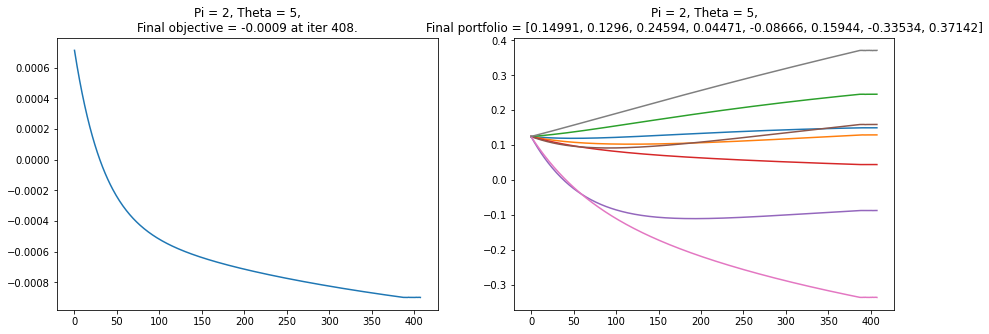

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize= (15, 5))

ax[0].plot(f_history[:it])
ax[1].plot(x_history[:it])

final_objective = round(f_history[it-1],5)
final_portfolio = [round(p,5) for p in x_history[it-1]]
print(f"Final objective = {final_objective}")
print(f"Final portfolio = {final_portfolio}")

ax[0].set_title(f"Pi = {pi}, Theta = {theta},\nFinal objective = {final_objective} at iter {it}.")
ax[1].set_title(f"Pi = {pi}, Theta = {theta},\nFinal portfolio = {final_portfolio}")

### Barrier Run: $\pi=4$, $\theta=1000$

In [26]:
ret = ret_train.values
pi = 4; theta = 1000; portfolio = np.array([1/8]*8)
lda = 1e-10
max_iter = 1000
m = len(portfolio)
x_history = np.zeros((max_iter, m))
f_history = np.zeros(max_iter)
it, converged = run_grad_desc_barrier(
    x = portfolio, x_star=x_star[1], lda=lda,
    ret = ret, 
    pi = pi, theta = theta, x_history = x_history, f_history = f_history,
    bt=True, bt_a=0.5, bt_b=0.6, bt_init_step=1,
    momentum=False, mom_mu=0.8, 
    max_iter = max_iter, step_eps=1e-4, 
)

print(f"Converged: {str(converged)}, after {it} iterations")

iter 0 :
new x: [0.12505225 0.12480526 0.12539354 0.12471763 0.12257585 0.12477943
 0.12253778 0.12577582]
grad 0 = [-5.22519237e-05  1.94741661e-04 -3.93542807e-04  2.82367947e-04
  2.42414579e-03  2.20569524e-04  2.46221693e-03 -7.75815238e-04]
grad L2 0 = 1.2864797397401004e-05
iter 100 :
new x: [ 0.15445343  0.11699847  0.18064041  0.10397607 -0.06230959  0.12198541
 -0.08327392  0.20859298]
grad 100 = [-3.89775587e-04  3.13311370e-05 -6.12264381e-04  1.76699781e-04
  1.61823724e-03 -4.84479426e-05  1.89613300e-03 -8.47305000e-04]
grad L2 100 = 7.493282185931604e-06
iter 200 :
new x: [ 0.19152259  0.11566724  0.24005208  0.08782781 -0.20757374  0.13016989
 -0.26241961  0.29163464]
grad 200 = [-3.31939198e-04 -1.47510577e-05 -5.63193653e-04  1.37907688e-04
  1.18294666e-03 -1.35215147e-04  1.62121918e-03 -8.02060505e-04]
grad L2 200 = 5.135905454460153e-06
iter 300 :
new x: [ 0.22049492  0.12232419  0.29299941  0.07824624 -0.28072836  0.15321841
 -0.39517065  0.36795602]
grad 300 = 

Final objective = -0.00172
Final portfolio = [0.23678, 0.13247, 0.32693, 0.07598, -0.28745, 0.17917, -0.4593, 0.41829]


Text(0.5, 1.0, 'Pi = 4, Theta = 1000,\nFinal portfolio = [0.23678, 0.13247, 0.32693, 0.07598, -0.28745, 0.17917, -0.4593, 0.41829]')

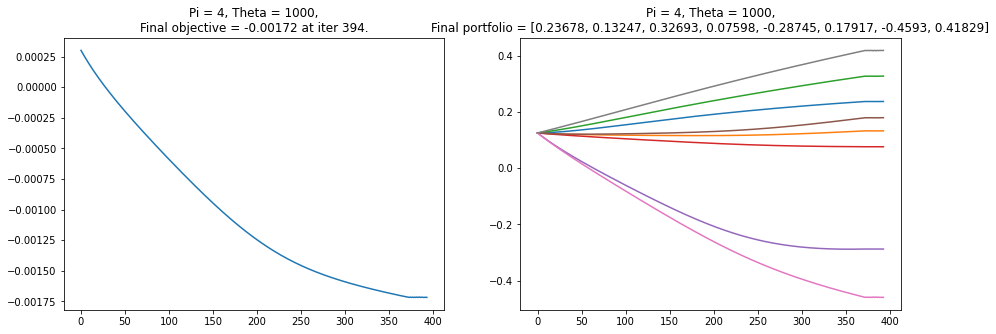

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize= (15, 5))

ax[0].plot(f_history[:it])
ax[1].plot(x_history[:it])

final_objective = round(f_history[it-1],5)
final_portfolio = [round(p,5) for p in x_history[it-1]]
print(f"Final objective = {final_objective}")
print(f"Final portfolio = {final_portfolio}")

ax[0].set_title(f"Pi = {pi}, Theta = {theta},\nFinal objective = {final_objective} at iter {it}.")
ax[1].set_title(f"Pi = {pi}, Theta = {theta},\nFinal portfolio = {final_portfolio}")